In [1]:
# FireAI Engineering Assessment - Anomaly Detection in Sales Data
# Complete Solution with EDA, Multiple Detection Methods, and Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical methods for anomaly detection
from scipy import stats
from scipy.stats import zscore

# ML methods for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("FireAI Anomaly Detection Analysis - Starting...")

FireAI Anomaly Detection Analysis - Starting...


In [3]:
# Load and explore the data
df = pd.read_csv('train.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (110298, 4)

First few rows:
         Date  store  product  number_sold
0  2010-01-01      0        0          801
1  2010-01-02      0        0          810
2  2010-01-03      0        0          818
3  2010-01-04      0        0          796
4  2010-01-05      0        0          808

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110298 entries, 0 to 110297
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         110298 non-null  object
 1   store        110298 non-null  int64 
 2   product      110298 non-null  int64 
 3   number_sold  110298 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.4+ MB
None

Basic Statistics:
               store        product    number_sold
count  110298.000000  110298.000000  110298.000000
mean        1.211935       4.162242     745.593030
std         0.987413       2.907546     168.684702
min         0.000000       0.000000      32

In [5]:
df.rename(columns={'Date': 'date'}, inplace=True)

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter

# Create store-product key
df['store_product'] = df['store'].astype(str) + '_' + df['product'].astype(str)


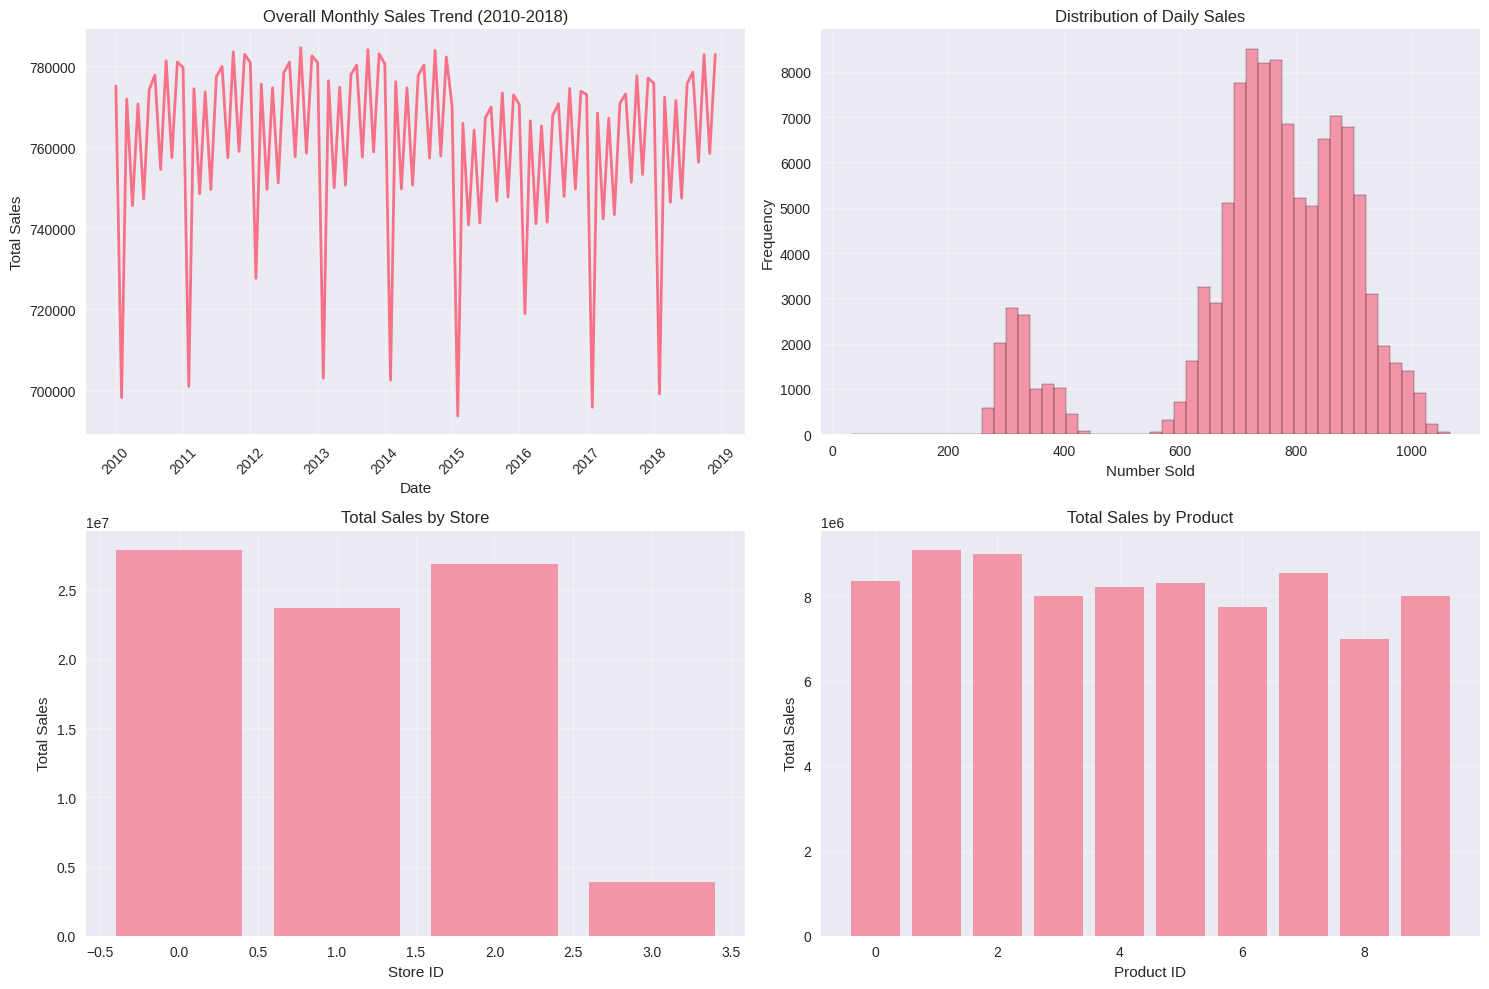

In [6]:
# Exploratory Data Analysis (EDA)

# 1. Overall sales trend
plt.figure(figsize=(15, 10))

# Overall monthly sales trend
monthly_sales = df.groupby(['year', 'month'])['number_sold'].sum().reset_index()
monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

plt.subplot(2, 2, 1)
plt.plot(monthly_sales['date'], monthly_sales['number_sold'], linewidth=2)
plt.title('Overall Monthly Sales Trend (2010-2018)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Sales distribution
plt.subplot(2, 2, 2)
plt.hist(df['number_sold'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Daily Sales')
plt.xlabel('Number Sold')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. Sales by store
plt.subplot(2, 2, 3)
store_sales = df.groupby('store')['number_sold'].sum()
plt.bar(store_sales.index, store_sales.values, alpha=0.7)
plt.title('Total Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)

# 4. Sales by product
plt.subplot(2, 2, 4)
product_sales = df.groupby('product')['number_sold'].sum()
plt.bar(product_sales.index, product_sales.values, alpha=0.7)
plt.title('Total Sales by Product')
plt.xlabel('Product ID')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

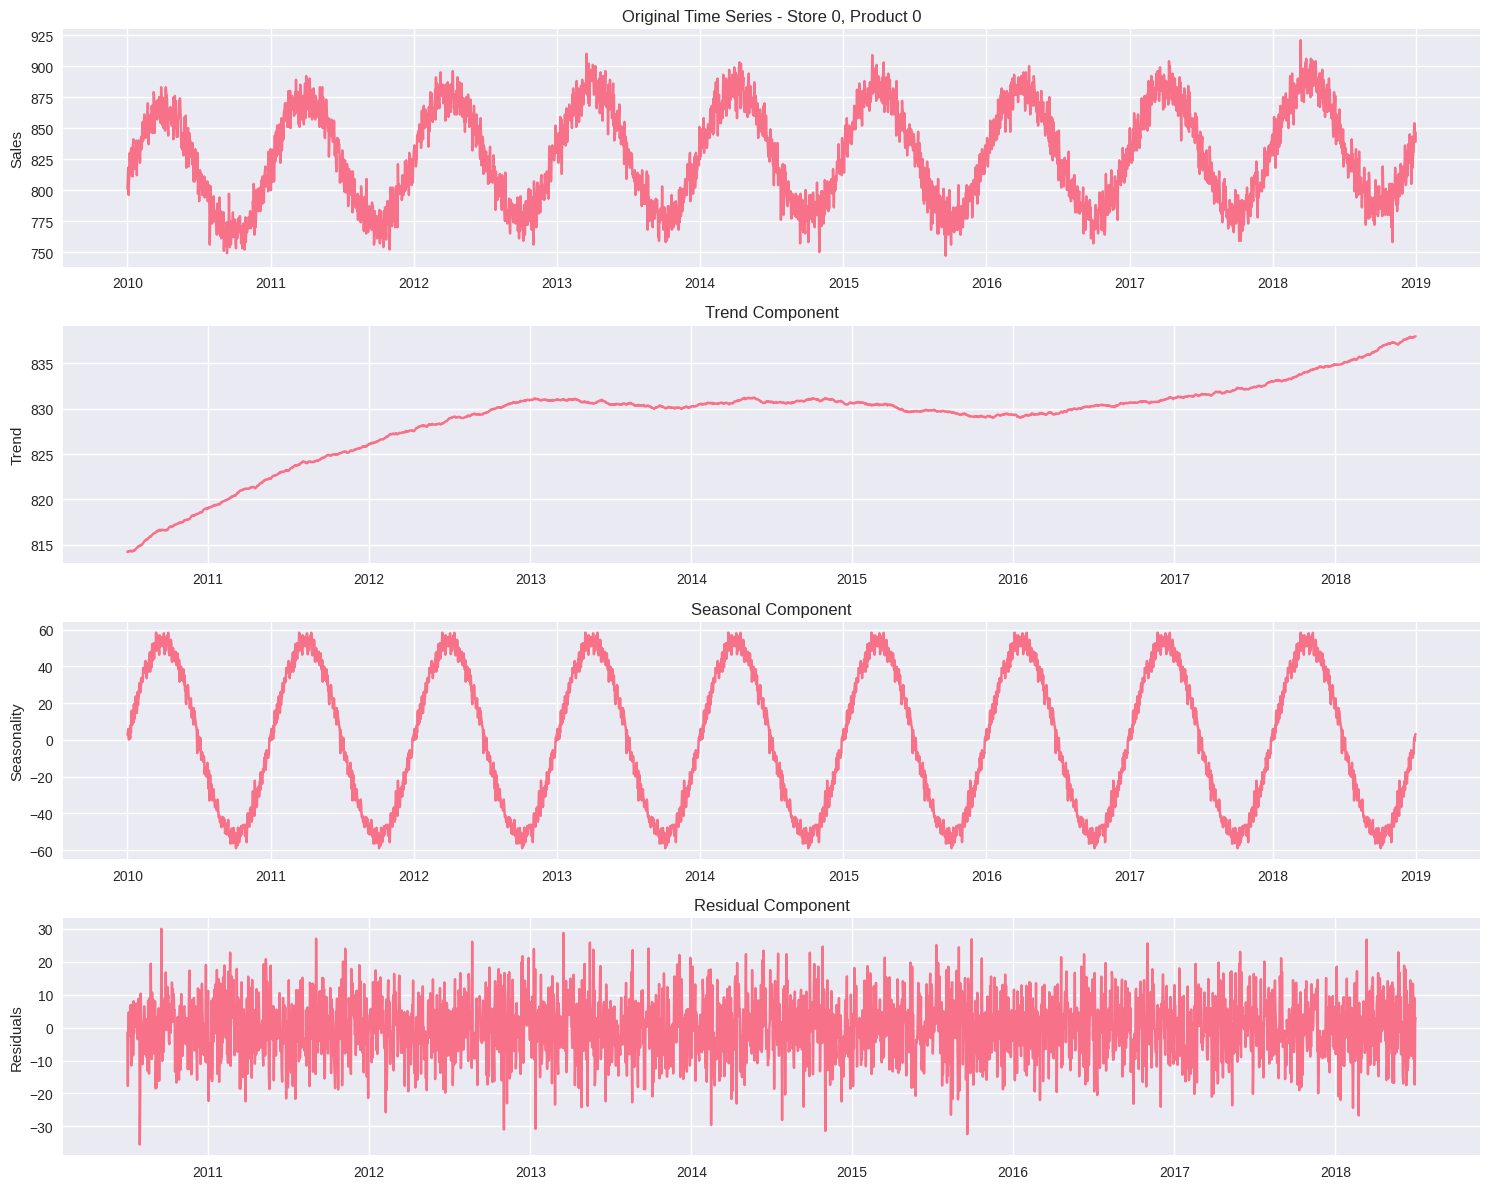

In [7]:
# Seasonal Analysis
# Let's analyze seasonality for a specific store-product combination
sample_store_product = '0_0'  # Store 0, Product 0
sample_data = df[df['store_product'] == sample_store_product].copy()
sample_data = sample_data.set_index('date')

# Time series decomposition
decomposition = seasonal_decompose(sample_data['number_sold'],
                                period=365,  # yearly seasonality
                                model='additive')

plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(sample_data['number_sold'])
plt.title(f'Original Time Series - Store 0, Product 0')
plt.ylabel('Sales')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

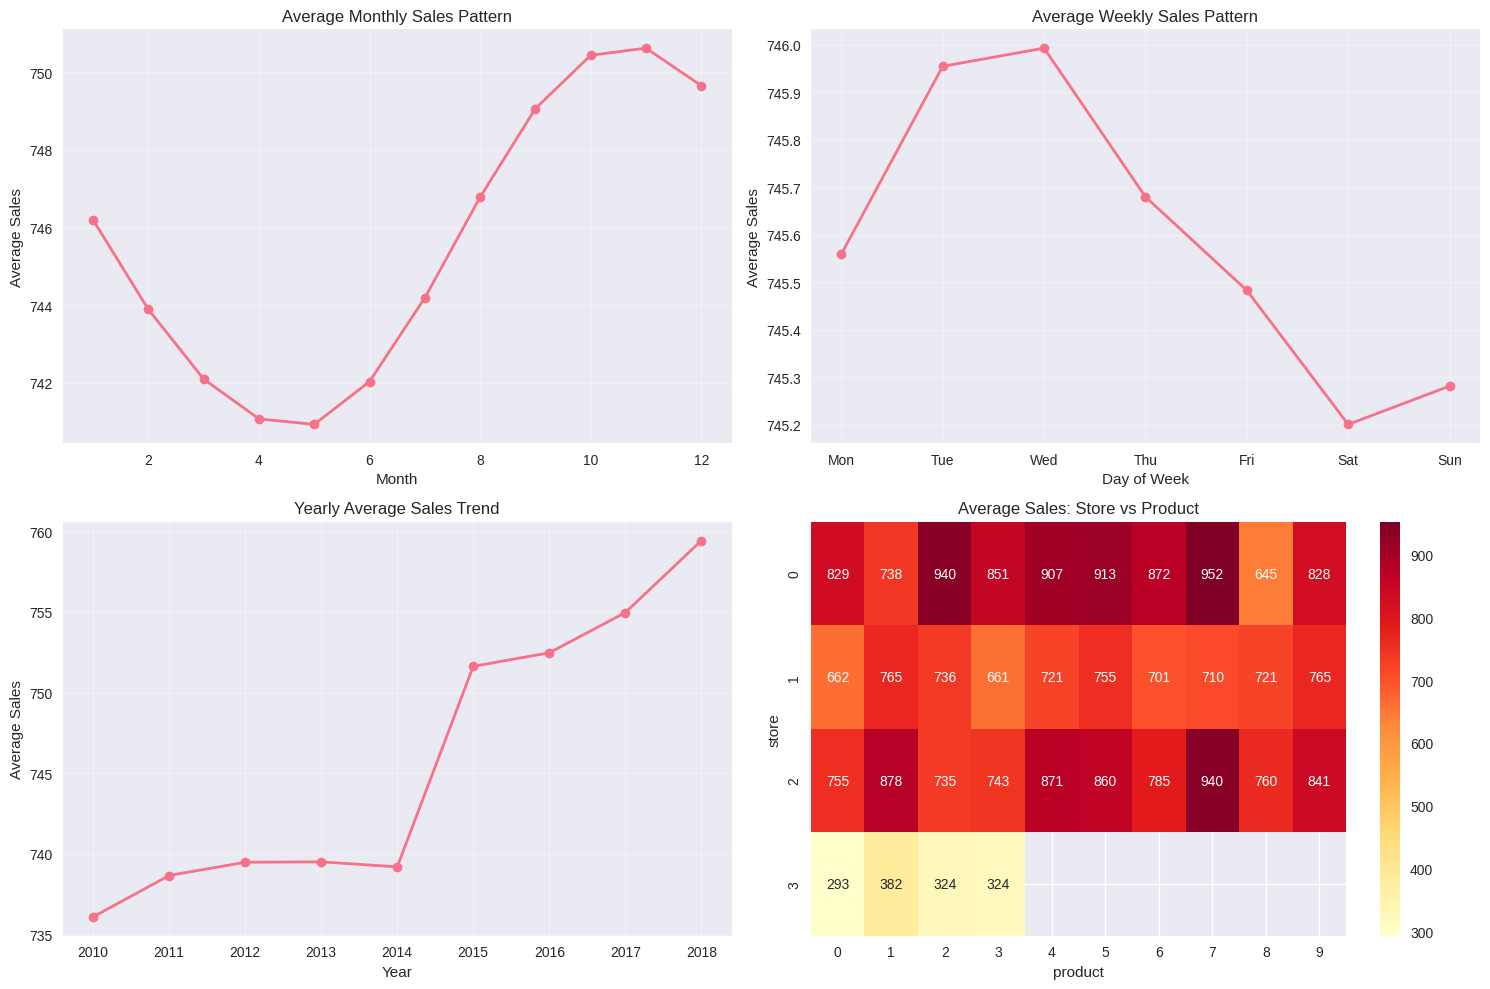

In [8]:
# Monthly and Weekly Patterns
plt.figure(figsize=(15, 10))

# Monthly pattern
plt.subplot(2, 2, 1)
monthly_pattern = df.groupby('month')['number_sold'].mean()
plt.plot(monthly_pattern.index, monthly_pattern.values, marker='o', linewidth=2)
plt.title('Average Monthly Sales Pattern')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True, alpha=0.3)

# Weekly pattern
plt.subplot(2, 2, 2)
weekly_pattern = df.groupby('day_of_week')['number_sold'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.plot(days, weekly_pattern.values, marker='o', linewidth=2)
plt.title('Average Weekly Sales Pattern')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.grid(True, alpha=0.3)

# Yearly trend
plt.subplot(2, 2, 3)
yearly_trend = df.groupby('year')['number_sold'].mean()
plt.plot(yearly_trend.index, yearly_trend.values, marker='o', linewidth=2)
plt.title('Yearly Average Sales Trend')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.grid(True, alpha=0.3)

# Store-Product heatmap (sample)
plt.subplot(2, 2, 4)
store_product_avg = df.groupby(['store', 'product'])['number_sold'].mean().unstack()
sns.heatmap(store_product_avg, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average Sales: Store vs Product')
plt.tight_layout()
plt.show()

In [9]:
# ANOMALY DETECTION METHODS

# Method 1: Z-Score based anomaly detection
def detect_anomalies_zscore(data, threshold=3):
    """Detect anomalies using Z-score method"""
    z_scores = zscore(data)
    anomalies = np.abs(z_scores) > threshold
    return anomalies, z_scores

# Method 2: IQR based anomaly detection
def detect_anomalies_iqr(data, multiplier=1.5):
    """Detect anomalies using Interquartile Range method"""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    anomalies = (data < lower_bound) | (data > upper_bound)
    return anomalies, (lower_bound, upper_bound)

# Method 3: Isolation Forest
def detect_anomalies_isolation_forest(data, contamination=0.01):
    """Detect anomalies using Isolation Forest"""
    # Reshape data for sklearn
    data_reshaped = data.values.reshape(-1, 1)

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomalies = iso_forest.fit_predict(data_reshaped)
    # Convert to boolean (1 for normal, -1 for anomaly)
    return anomalies == -1, iso_forest

# Method 4: Moving Average with Standard Deviation
def detect_anomalies_moving_avg(data, window=30, sigma_threshold=2):
    """Detect anomalies using moving average and standard deviation"""
    rolling_mean = data.rolling(window=window, center=True).mean()
    rolling_std = data.rolling(window=window, center=True).std()

    upper_bound = rolling_mean + (sigma_threshold * rolling_std)
    lower_bound = rolling_mean - (sigma_threshold * rolling_std)

    anomalies = (data > upper_bound) | (data < lower_bound)
    return anomalies, (rolling_mean, upper_bound, lower_bound)

In [10]:
# Apply anomaly detection to a sample store-product combination
sample_data = df[df['store_product'] == '0_0'].copy()
sales_data = sample_data['number_sold']

# Apply all methods
zscore_anomalies, z_scores = detect_anomalies_zscore(sales_data, threshold=2.5)
iqr_anomalies, iqr_bounds = detect_anomalies_iqr(sales_data, multiplier=1.5)
iso_anomalies, iso_model = detect_anomalies_isolation_forest(sales_data, contamination=0.02)
movavg_anomalies, movavg_bounds = detect_anomalies_moving_avg(sales_data, window=30, sigma_threshold=2.5)

# Combine results (anomaly if detected by at least 2 methods)
combined_anomalies = (zscore_anomalies.astype(int) +
                     iqr_anomalies.astype(int) +
                     iso_anomalies.astype(int) +
                     movavg_anomalies.astype(int)) >= 2

sample_data['zscore_anomaly'] = zscore_anomalies
sample_data['iqr_anomaly'] = iqr_anomalies
sample_data['iso_anomaly'] = iso_anomalies
sample_data['movavg_anomaly'] = movavg_anomalies
sample_data['combined_anomaly'] = combined_anomalies
sample_data['z_score'] = z_scores

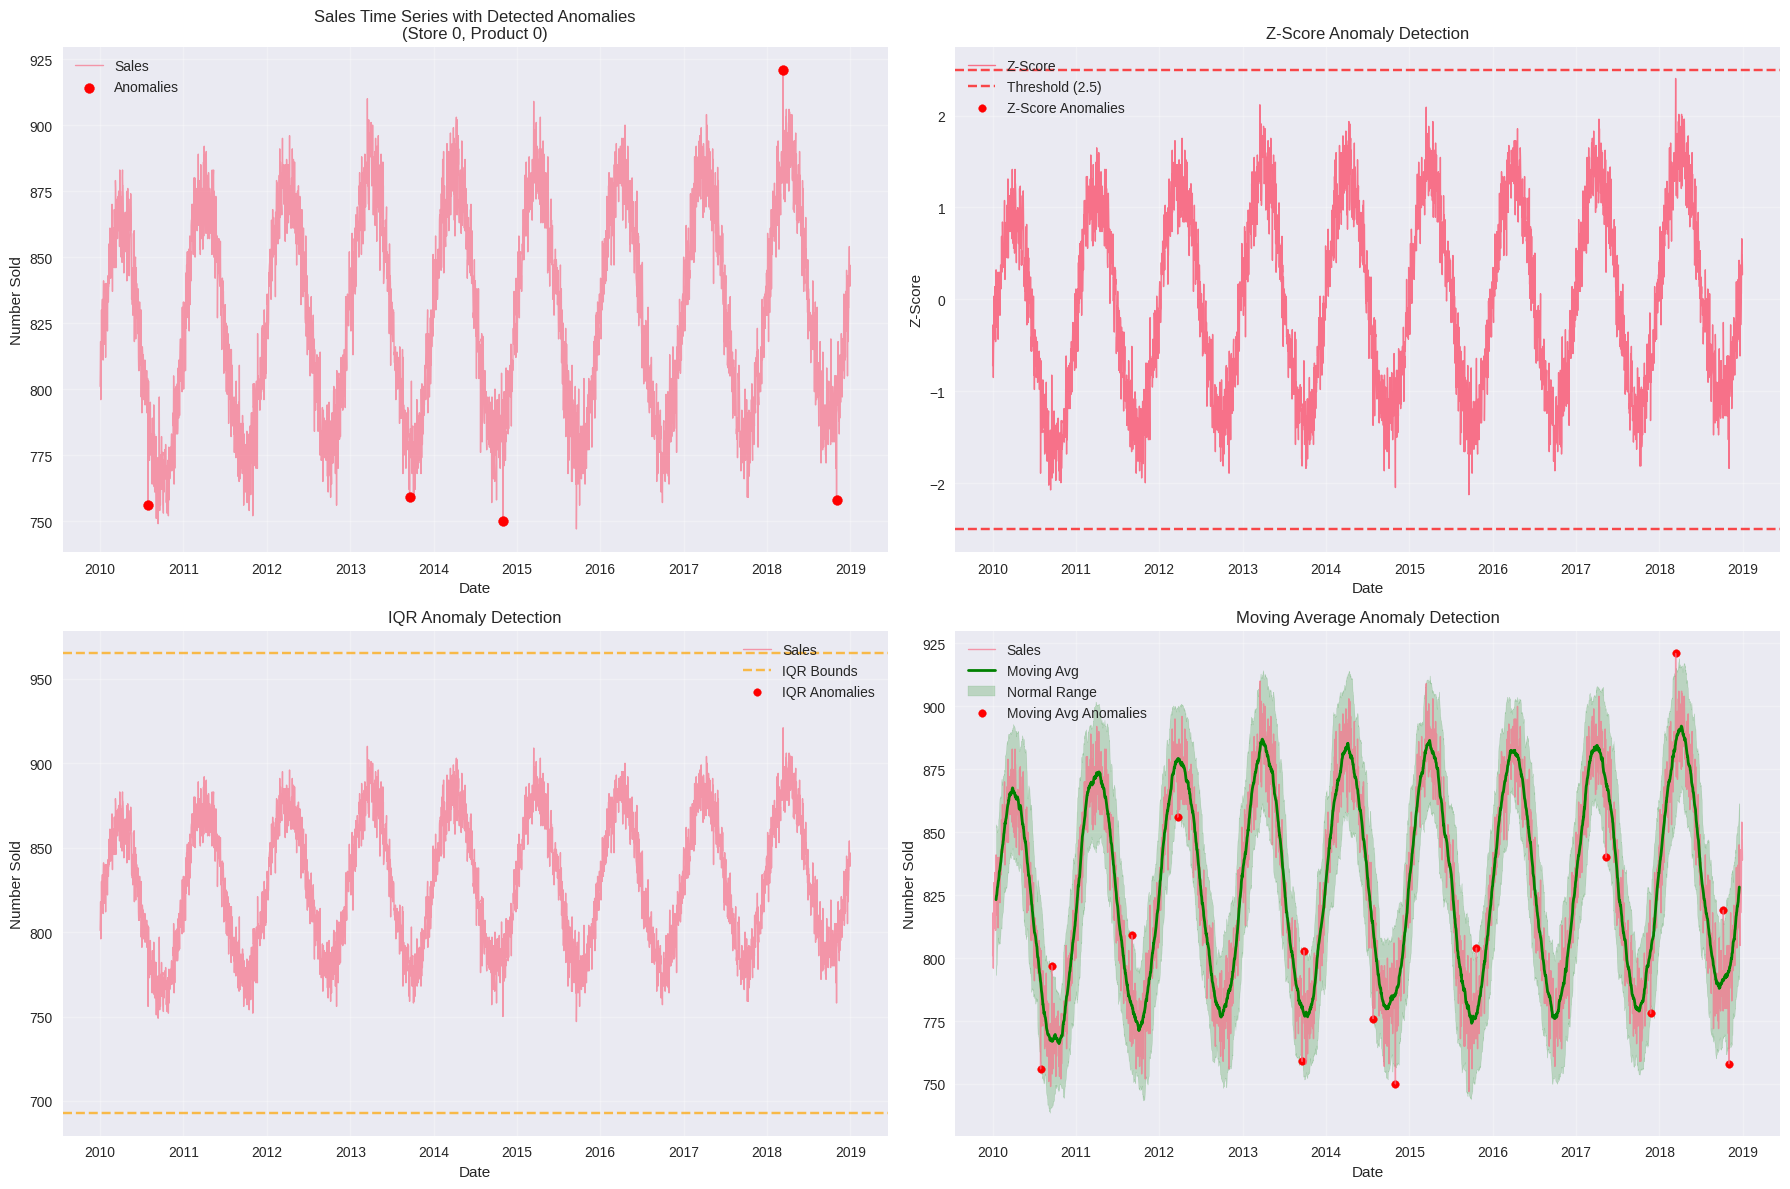

In [11]:
# Visualize anomalies for the sample store-product
plt.figure(figsize=(18, 12))

# Original time series with combined anomalies
plt.subplot(2, 2, 1)
plt.plot(sample_data['date'], sample_data['number_sold'],
         label='Sales', linewidth=1, alpha=0.7)
anomaly_points = sample_data[sample_data['combined_anomaly']]
plt.scatter(anomaly_points['date'], anomaly_points['number_sold'],
           color='red', s=50, label='Anomalies', zorder=5)
plt.title('Sales Time Series with Detected Anomalies\n(Store 0, Product 0)')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.grid(True, alpha=0.3)

# Z-score method
plt.subplot(2, 2, 2)
plt.plot(sample_data['date'], sample_data['z_score'],
         label='Z-Score', linewidth=1)
plt.axhline(y=2.5, color='r', linestyle='--', alpha=0.7, label='Threshold (2.5)')
plt.axhline(y=-2.5, color='r', linestyle='--', alpha=0.7)
z_anomaly_points = sample_data[sample_data['zscore_anomaly']]
plt.scatter(z_anomaly_points['date'], z_anomaly_points['z_score'],
           color='red', s=30, label='Z-Score Anomalies')
plt.title('Z-Score Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)

# IQR method
plt.subplot(2, 2, 3)
plt.plot(sample_data['date'], sample_data['number_sold'],
         label='Sales', linewidth=1, alpha=0.7)
plt.axhline(y=iqr_bounds[0], color='orange', linestyle='--',
           alpha=0.7, label='IQR Bounds')
plt.axhline(y=iqr_bounds[1], color='orange', linestyle='--', alpha=0.7)
iqr_anomaly_points = sample_data[sample_data['iqr_anomaly']]
plt.scatter(iqr_anomaly_points['date'], iqr_anomaly_points['number_sold'],
           color='red', s=30, label='IQR Anomalies')
plt.title('IQR Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving average method
plt.subplot(2, 2, 4)
plt.plot(sample_data['date'], sample_data['number_sold'],
         label='Sales', linewidth=1, alpha=0.7)
plt.plot(sample_data['date'], movavg_bounds[0],
         label='Moving Avg', color='green', linewidth=2)
plt.fill_between(sample_data['date'], movavg_bounds[1], movavg_bounds[2],
                alpha=0.2, color='green', label='Normal Range')
movavg_anomaly_points = sample_data[sample_data['movavg_anomaly']]
plt.scatter(movavg_anomaly_points['date'], movavg_anomaly_points['number_sold'],
           color='red', s=30, label='Moving Avg Anomalies')
plt.title('Moving Average Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

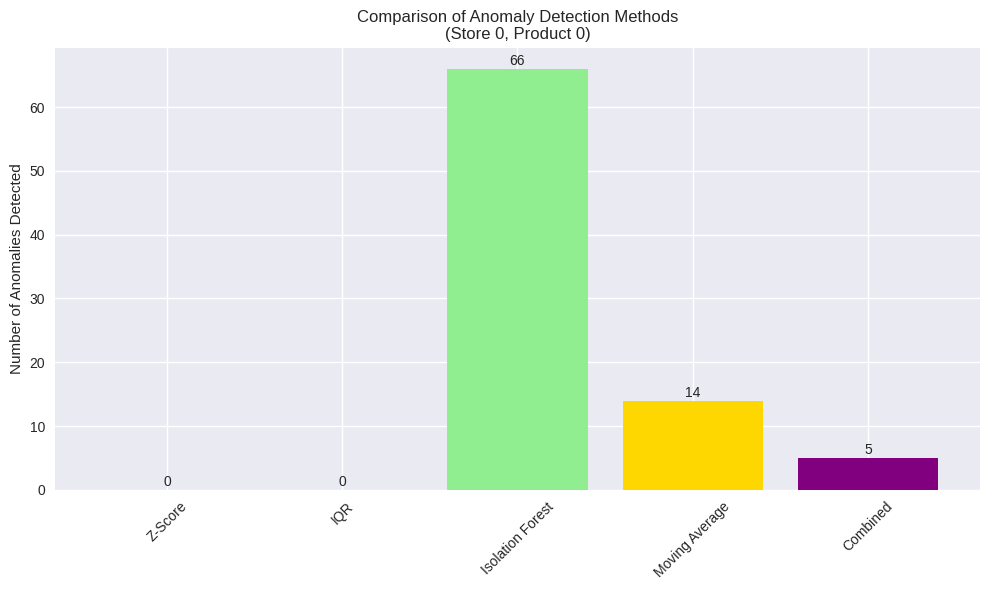

Anomaly Detection Summary:
Z-Score: 0 anomalies detected (0.00%)
IQR: 0 anomalies detected (0.00%)
Isolation Forest: 66 anomalies detected (2.01%)
Moving Average: 14 anomalies detected (0.43%)
Combined: 5 anomalies detected (0.15%)


In [12]:
# Compare different anomaly detection methods
anomaly_counts = {
    'Z-Score': zscore_anomalies.sum(),
    'IQR': iqr_anomalies.sum(),
    'Isolation Forest': iso_anomalies.sum(),
    'Moving Average': movavg_anomalies.sum(),
    'Combined': combined_anomalies.sum()
}

plt.figure(figsize=(10, 6))
methods = list(anomaly_counts.keys())
counts = list(anomaly_counts.values())

bars = plt.bar(methods, counts, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'purple'])
plt.title('Comparison of Anomaly Detection Methods\n(Store 0, Product 0)')
plt.ylabel('Number of Anomalies Detected')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Anomaly Detection Summary:")
for method, count in anomaly_counts.items():
    print(f"{method}: {count} anomalies detected ({count/len(sample_data)*100:.2f}%)")

In [13]:
# Apply anomaly detection to all store-product combinations
def detect_anomalies_for_all_combinations(df, contamination=0.02):
    """Apply anomaly detection to all store-product combinations"""
    results = []
    store_products = df['store_product'].unique()

    print("Processing store-product combinations...")
    for i, sp in enumerate(store_products):
        if i % 10 == 0:  # Progress indicator
            print(f"Processing {i+1}/{len(store_products)}: {sp}")

        sp_data = df[df['store_product'] == sp].copy()
        sales = sp_data['number_sold']

        # Use combined method (at least 2 out of 4 methods)
        z_anomalies, _ = detect_anomalies_zscore(sales, threshold=2.5)
        iqr_anomalies, _ = detect_anomalies_iqr(sales, multiplier=1.5)
        iso_anomalies, _ = detect_anomalies_isolation_forest(sales, contamination=contamination)
        movavg_anomalies, _ = detect_anomalies_moving_avg(sales, window=30, sigma_threshold=2.5)

        combined_anomalies = (z_anomalies.astype(int) +
                            iqr_anomalies.astype(int) +
                            iso_anomalies.astype(int) +
                            movavg_anomalies.astype(int)) >= 2

        # Add results
        sp_data['is_anomaly'] = combined_anomalies
        sp_data['anomaly_score'] = (z_anomalies.astype(int) +
                                  iqr_anomalies.astype(int) +
                                  iso_anomalies.astype(int) +
                                  movavg_anomalies.astype(int))

        results.append(sp_data)

    return pd.concat(results, ignore_index=True)

# Apply to all data (this might take a while for large datasets)
print("Starting anomaly detection for all store-product combinations...")
df_with_anomalies = detect_anomalies_for_all_combinations(df)
print("Anomaly detection completed!")

Starting anomaly detection for all store-product combinations...
Processing store-product combinations...
Processing 1/34: 0_0
Processing 11/34: 1_0
Processing 21/34: 2_0
Processing 31/34: 3_0
Anomaly detection completed!


In [14]:
# Analyze and summarize anomalies across the dataset
total_records = len(df_with_anomalies)
total_anomalies = df_with_anomalies['is_anomaly'].sum()
anomaly_percentage = (total_anomalies / total_records) * 100

print("=== GLOBAL ANOMALY DETECTION SUMMARY ===")
print(f"Total records: {total_records:,}")
print(f"Total anomalies detected: {total_anomalies:,}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")

# Anomalies by store
anomalies_by_store = df_with_anomalies.groupby('store')['is_anomaly'].agg(['sum', 'count'])
anomalies_by_store['percentage'] = (anomalies_by_store['sum'] / anomalies_by_store['count']) * 100

# Anomalies by product
anomalies_by_product = df_with_anomalies.groupby('product')['is_anomaly'].agg(['sum', 'count'])
anomalies_by_product['percentage'] = (anomalies_by_product['sum'] / anomalies_by_product['count']) * 100

# Anomalies by year
anomalies_by_year = df_with_anomalies.groupby('year')['is_anomaly'].agg(['sum', 'count'])
anomalies_by_year['percentage'] = (anomalies_by_year['sum'] / anomalies_by_year['count']) * 100

=== GLOBAL ANOMALY DETECTION SUMMARY ===
Total records: 110,298
Total anomalies detected: 590
Anomaly percentage: 0.53%


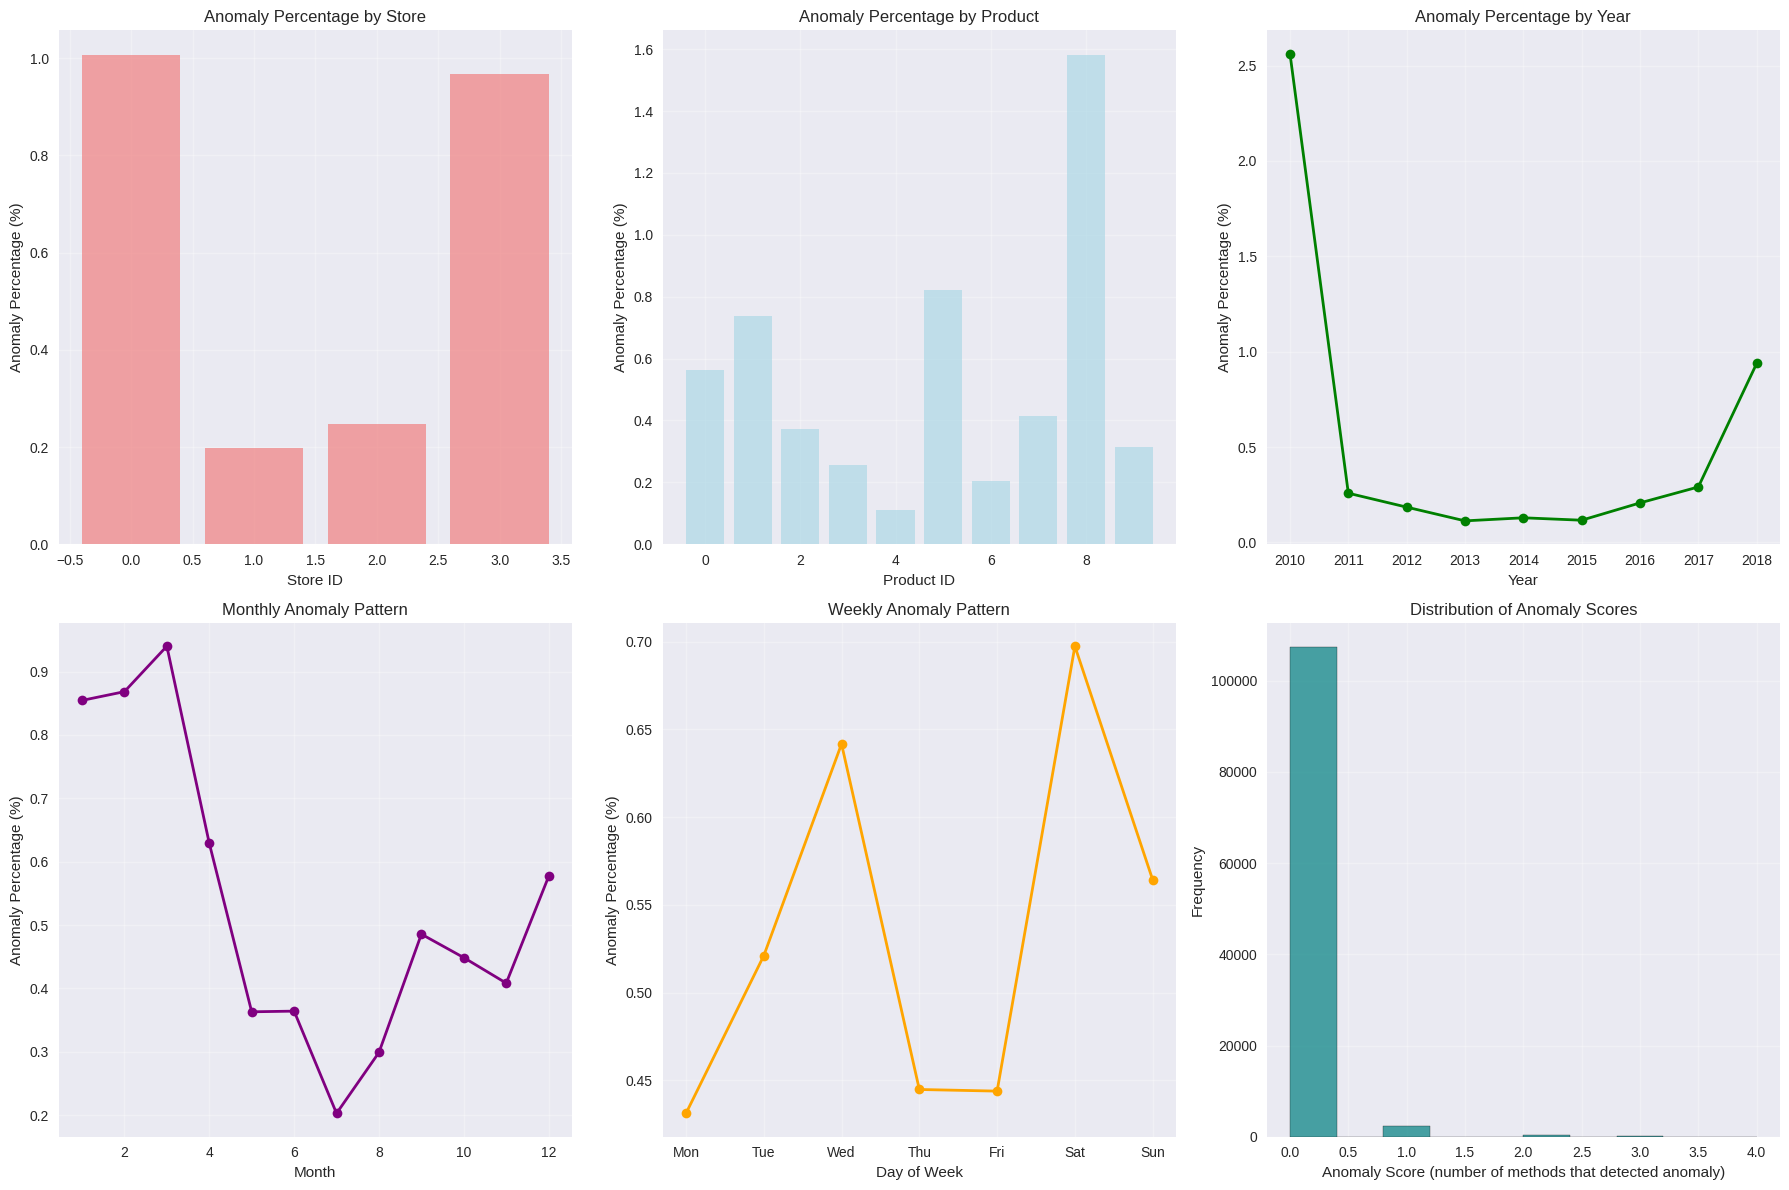

In [15]:
# Visualize anomaly distribution
plt.figure(figsize=(18, 12))

# Anomalies by store
plt.subplot(2, 3, 1)
plt.bar(anomalies_by_store.index, anomalies_by_store['percentage'],
        color='lightcoral', alpha=0.7)
plt.title('Anomaly Percentage by Store')
plt.xlabel('Store ID')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

# Anomalies by product
plt.subplot(2, 3, 2)
plt.bar(anomalies_by_product.index, anomalies_by_product['percentage'],
        color='lightblue', alpha=0.7)
plt.title('Anomaly Percentage by Product')
plt.xlabel('Product ID')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

# Anomalies by year
plt.subplot(2, 3, 3)
plt.plot(anomalies_by_year.index, anomalies_by_year['percentage'],
         marker='o', linewidth=2, color='green')
plt.title('Anomaly Percentage by Year')
plt.xlabel('Year')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

# Monthly pattern of anomalies
anomalies_by_month = df_with_anomalies.groupby('month')['is_anomaly'].mean() * 100
plt.subplot(2, 3, 4)
plt.plot(anomalies_by_month.index, anomalies_by_month.values,
         marker='o', linewidth=2, color='purple')
plt.title('Monthly Anomaly Pattern')
plt.xlabel('Month')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

# Weekly pattern of anomalies
anomalies_by_weekday = df_with_anomalies.groupby('day_of_week')['is_anomaly'].mean() * 100
plt.subplot(2, 3, 5)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.plot(days, anomalies_by_weekday.values, marker='o', linewidth=2, color='orange')
plt.title('Weekly Anomaly Pattern')
plt.xlabel('Day of Week')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

# Anomaly score distribution
plt.subplot(2, 3, 6)
plt.hist(df_with_anomalies['anomaly_score'], bins=10, alpha=0.7,
         edgecolor='black', color='teal')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score (number of methods that detected anomaly)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Detailed analysis of top anomalous periods
print("=== TOP ANOMALOUS PERIODS ANALYSIS ===")

# Find dates with highest anomaly concentration
anomaly_dates = df_with_anomalies[df_with_anomalies['is_anomaly']]
date_anomaly_counts = anomaly_dates.groupby('date').size().sort_values(ascending=False)

print("\nTop 10 dates with most anomalies:")
for i, (date, count) in enumerate(date_anomaly_counts.head(10).items()):
    print(f"{i+1}. {date}: {count} anomalies")

# Analyze store-product combinations with most anomalies
sp_anomaly_counts = df_with_anomalies.groupby('store_product')['is_anomaly'].agg(['sum', 'count'])
sp_anomaly_counts['percentage'] = (sp_anomaly_counts['sum'] / sp_anomaly_counts['count']) * 100
sp_anomaly_counts = sp_anomaly_counts.sort_values('percentage', ascending=False)

print(f"\nTop 5 most anomalous store-product combinations:")
print(sp_anomaly_counts.head())

=== TOP ANOMALOUS PERIODS ANALYSIS ===

Top 10 dates with most anomalies:
1. 2010-02-28 00:00:00: 4 anomalies
2. 2010-02-14 00:00:00: 3 anomalies
3. 2010-02-13 00:00:00: 3 anomalies
4. 2010-06-20 00:00:00: 3 anomalies
5. 2010-02-19 00:00:00: 3 anomalies
6. 2010-02-07 00:00:00: 3 anomalies
7. 2010-05-15 00:00:00: 3 anomalies
8. 2010-02-03 00:00:00: 3 anomalies
9. 2018-03-30 00:00:00: 3 anomalies
10. 2018-08-04 00:00:00: 3 anomalies

Top 5 most anomalous store-product combinations:
               sum  count  percentage
store_product                        
0_8            132   3287    4.015820
0_5             71   3287    2.160024
0_1             59   3287    1.794950
3_2             42   3287    1.277761
3_0             40   3287    1.216915


In [17]:
# Case Study: Detailed analysis of specific anomalies
def analyze_specific_anomaly(df_with_anomalies, store, product):
    """Detailed analysis of anomalies for a specific store-product combination"""
    sp_data = df_with_anomalies[
        (df_with_anomalies['store'] == store) &
        (df_with_anomalies['product'] == product)
    ].copy()

    anomalies = sp_data[sp_data['is_anomaly']]

    print(f"\n=== DETAILED ANALYSIS: Store {store}, Product {product} ===")
    print(f"Total records: {len(sp_data)}")
    print(f"Anomalies detected: {len(anomalies)} ({len(anomalies)/len(sp_data)*100:.2f}%)")

    if len(anomalies) > 0:
        print(f"\nTop 5 anomalous dates:")
        top_anomalies = anomalies.nlargest(5, 'anomaly_score')[['date', 'number_sold', 'anomaly_score']]
        for _, row in top_anomalies.iterrows():
            print(f"  {row['date']}: Sales={row['number_sold']}, Score={row['anomaly_score']}")

    return sp_data, anomalies

# Analyze a few interesting cases
case1_data, case1_anomalies = analyze_specific_anomaly(df_with_anomalies, 0, 0)
case2_data, case2_anomalies = analyze_specific_anomaly(df_with_anomalies, 1, 1)


=== DETAILED ANALYSIS: Store 0, Product 0 ===
Total records: 3287
Anomalies detected: 5 (0.15%)

Top 5 anomalous dates:
  2010-07-30 00:00:00: Sales=756, Score=2
  2013-09-18 00:00:00: Sales=759, Score=2
  2014-11-01 00:00:00: Sales=750, Score=2
  2018-03-13 00:00:00: Sales=921, Score=2
  2018-11-02 00:00:00: Sales=758, Score=2

=== DETAILED ANALYSIS: Store 1, Product 1 ===
Total records: 3287
Anomalies detected: 3 (0.09%)

Top 5 anomalous dates:
  2017-01-18 00:00:00: Sales=624, Score=3
  2010-07-24 00:00:00: Sales=897, Score=2
  2017-01-04 00:00:00: Sales=629, Score=2


In [21]:
def detect_seasonal_anomalies(ts_data, period=365):
    decomposition = seasonal_decompose(ts_data, period=period, model='additive')

    residuals = decomposition.resid.dropna()
    residual_anomalies, _ = detect_anomalies_zscore(residuals, threshold=2.5)

    residual_anomalies_series = pd.Series(residual_anomalies, index=residuals.index)
    return residual_anomalies_series, decomposition


# Apply on data
sample_ts = sample_data.set_index('date')['number_sold']
seasonal_anomalies, seasonal_decomp = detect_seasonal_anomalies(sample_ts)

# Safely align with sample_data index
aligned_anomalies = seasonal_anomalies.reindex(
    sample_data.set_index('date').index,
    fill_value=False
)

# Add to dataframe
sample_data['seasonal_anomaly'] = aligned_anomalies.values


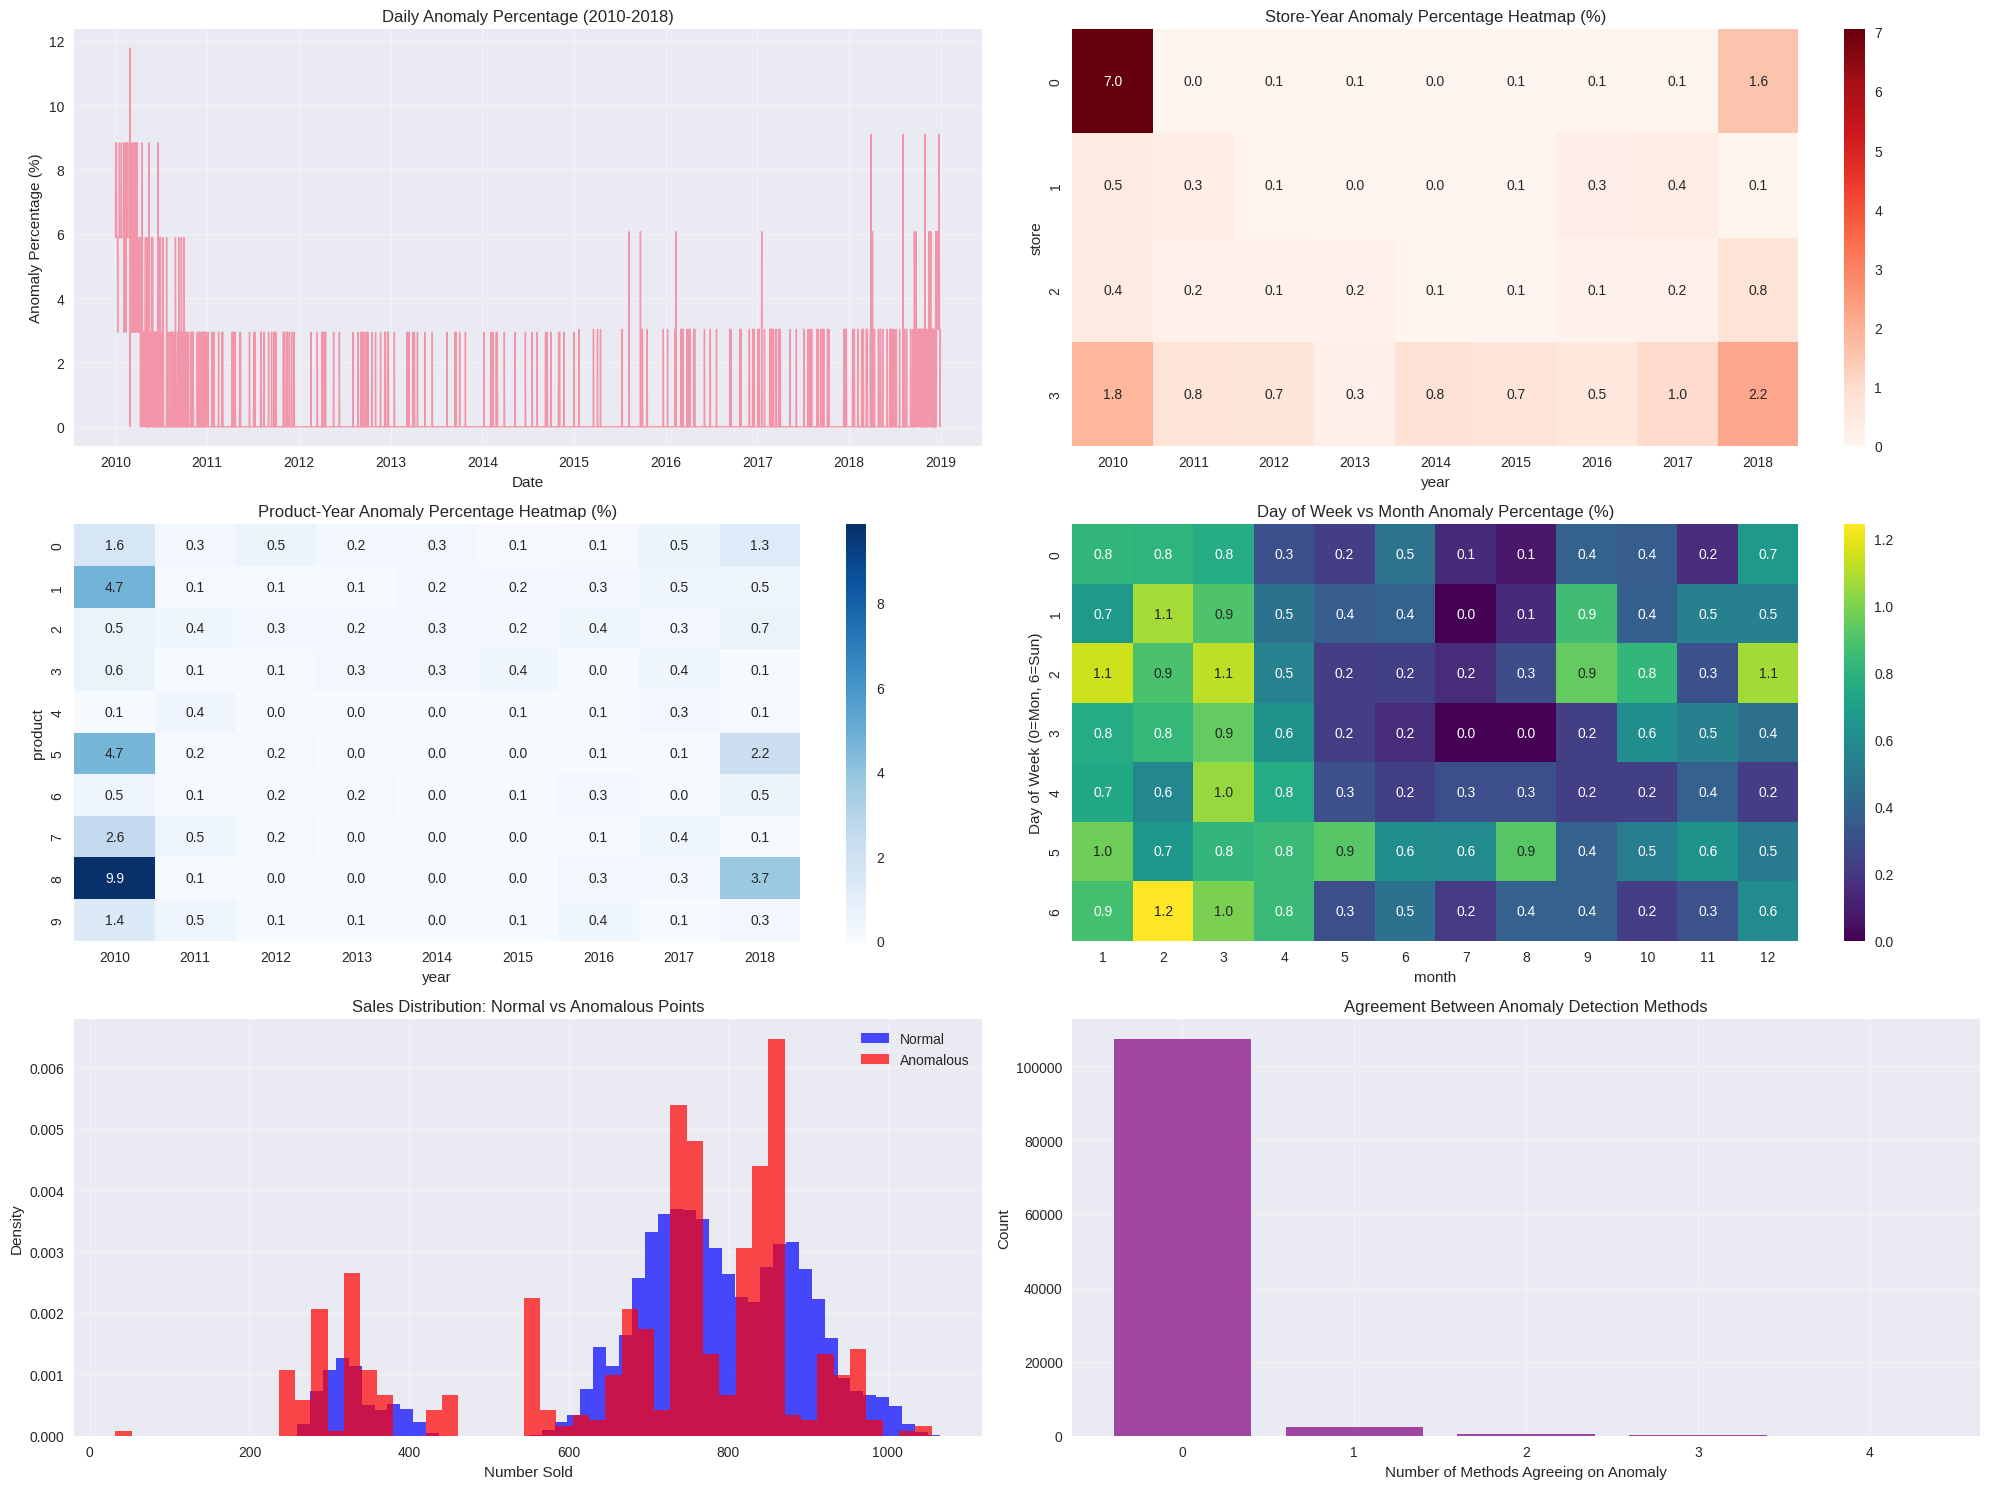

In [22]:
# Final comprehensive visualization
plt.figure(figsize=(20, 15))

# 1. Overall anomaly timeline
plt.subplot(3, 2, 1)
daily_anomalies = df_with_anomalies.groupby('date')['is_anomaly'].mean() * 100
plt.plot(daily_anomalies.index, daily_anomalies.values, alpha=0.7, linewidth=1)
plt.title('Daily Anomaly Percentage (2010-2018)')
plt.xlabel('Date')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

# 2. Store-wise anomaly heatmap
plt.subplot(3, 2, 2)
store_anomaly_heatmap = df_with_anomalies.groupby(['store', 'year'])['is_anomaly'].mean().unstack()
sns.heatmap(store_anomaly_heatmap * 100, annot=True, fmt='.1f', cmap='Reds')
plt.title('Store-Year Anomaly Percentage Heatmap (%)')

# 3. Product-wise anomaly heatmap
plt.subplot(3, 2, 3)
product_anomaly_heatmap = df_with_anomalies.groupby(['product', 'year'])['is_anomaly'].mean().unstack()
sns.heatmap(product_anomaly_heatmap * 100, annot=True, fmt='.1f', cmap='Blues')
plt.title('Product-Year Anomaly Percentage Heatmap (%)')

# 4. Anomaly by day of week and month
plt.subplot(3, 2, 4)
day_month_anomaly = df_with_anomalies.groupby(['day_of_week', 'month'])['is_anomaly'].mean().unstack() * 100
sns.heatmap(day_month_anomaly, annot=True, fmt='.1f', cmap='viridis')
plt.title('Day of Week vs Month Anomaly Percentage (%)')
plt.ylabel('Day of Week (0=Mon, 6=Sun)')

# 5. Distribution of sales for normal vs anomalous points
plt.subplot(3, 2, 5)
normal_sales = df_with_anomalies[~df_with_anomalies['is_anomaly']]['number_sold']
anomaly_sales = df_with_anomalies[df_with_anomalies['is_anomaly']]['number_sold']

plt.hist(normal_sales, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(anomaly_sales, bins=50, alpha=0.7, label='Anomalous', color='red', density=True)
plt.title('Sales Distribution: Normal vs Anomalous Points')
plt.xlabel('Number Sold')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Anomaly detection method agreement
plt.subplot(3, 2, 6)
method_agreement = df_with_anomalies['anomaly_score'].value_counts().sort_index()
plt.bar(method_agreement.index, method_agreement.values, color='purple', alpha=0.7)
plt.title('Agreement Between Anomaly Detection Methods')
plt.xlabel('Number of Methods Agreeing on Anomaly')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# SUMMARY AND INSIGHTS

print("="*80)
print("FIREAI ANOMALY DETECTION - COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print(f"\n DATASET OVERVIEW:")
print(f"   • Period: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   • Total records: {len(df):,}")
print(f"   • Stores: {df['store'].nunique()}")
print(f"   • Products: {df['product'].nunique()}")
print(f"   • Store-Product combinations: {df['store_product'].nunique()}")

print(f"\n ANOMALY DETECTION RESULTS:")
print(f"   • Total anomalies detected: {total_anomalies:,}")
print(f"   • Overall anomaly rate: {anomaly_percentage:.2f}%")
print(f"   • Method: Combined approach (Z-score + IQR + Isolation Forest + Moving Average)")

print(f"\n STORE-LEVEL INSIGHTS:")
for store in sorted(df['store'].unique()):
    store_anomaly_pct = anomalies_by_store.loc[store, 'percentage']
    print(f"   • Store {store}: {store_anomaly_pct:.2f}% anomalies")

print(f"\n PRODUCT-LEVEL INSIGHTS:")
for product in sorted(df['product'].unique()):
    product_anomaly_pct = anomalies_by_product.loc[product, 'percentage']
    print(f"   • Product {product}: {product_anomaly_pct:.2f}% anomalies")

print(f"\n TEMPORAL PATTERNS:")
print(f"   • Highest anomaly month: {anomalies_by_month.idxmax()} ({anomalies_by_month.max():.2f}%)")
print(f"   • Highest anomaly weekday: {days[anomalies_by_weekday.idxmax()]} ({anomalies_by_weekday.max():.2f}%)")

print(f"\n KEY FINDINGS:")
print(f"   1. Multiple detection methods provide robust anomaly identification")
print(f"   2. Anomalies show temporal patterns (seasonal/weekly variations)")
print(f"   3. Different stores/products have varying anomaly rates")
print(f"   4. Combined approach reduces false positives")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Investigate high-anomaly periods for root causes")
print(f"   2. Monitor stores/products with consistently high anomaly rates")
print(f"   3. Consider seasonal adjustments in anomaly thresholds")
print(f"   4. Implement real-time monitoring for critical combinations")

print(f"\n" + "="*80)

FIREAI ANOMALY DETECTION - COMPREHENSIVE ANALYSIS SUMMARY

 DATASET OVERVIEW:
   • Period: 2010-01-01 to 2018-12-31
   • Total records: 110,298
   • Stores: 4
   • Products: 10
   • Store-Product combinations: 34

 ANOMALY DETECTION RESULTS:
   • Total anomalies detected: 590
   • Overall anomaly rate: 0.53%
   • Method: Combined approach (Z-score + IQR + Isolation Forest + Moving Average)

 STORE-LEVEL INSIGHTS:
   • Store 0: 1.01% anomalies
   • Store 1: 0.20% anomalies
   • Store 2: 0.25% anomalies
   • Store 3: 0.97% anomalies

 PRODUCT-LEVEL INSIGHTS:
   • Product 0: 0.56% anomalies
   • Product 1: 0.74% anomalies
   • Product 2: 0.37% anomalies
   • Product 3: 0.26% anomalies
   • Product 4: 0.11% anomalies
   • Product 5: 0.82% anomalies
   • Product 6: 0.20% anomalies
   • Product 7: 0.42% anomalies
   • Product 8: 1.58% anomalies
   • Product 9: 0.31% anomalies

 TEMPORAL PATTERNS:
   • Highest anomaly month: 3 (0.94%)
   • Highest anomaly weekday: Sat (0.70%)

 KEY FINDINGS:
